In [91]:
import warnings
warnings.filterwarnings("ignore")

Custom libraries

In [92]:
import sys                                                                # Import the sys
sys.path.append('/gpfs/hpc/home/laasfeld/internship/NucleiDetection/')    # Add libary to the path
sys.path.append('/gpfs/hpc/home/papkov/universal-segmenter/')             

import database_lib as DL                                                 # Import the database_lib
from uniseg.utils import metrics

In [93]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Create database

In [3]:
database = DL.KP_database() # Create the database object
database.set_read_mode(DL.Read_mode.HDF5)

Find all the images with manual ground truth available

In [117]:
urls = np.unique(database.get_ground_truth_parameter_with_filter('Image_URL', GT_type=['Manual']))
print('Images with ground truth:', len(urls))
print(urls[:5])

Images with ground truth: 10
['24a3d729-de41-4b38-80b3-6a45d650e7d4.tiff'
 '50fb061c-eba1-4ce6-85c9-df10075fcf35.tiff'
 '57e3067c-f8cb-4705-9441-669a1ca67b58.tiff'
 '666dc6ca-b997-442e-adf0-bfefbd92bc5a.tiff'
 '6a95a8cf-5b96-4e06-9707-88be4fda6d73.tiff']


Read Acapella segmentation

In [118]:
acapella_gt, urls = database.get_acapella_GT(vote_mode='majority', Image_URL=urls)
acapella_gt = acapella_gt.astype(np.uint8)
acapella_gt.shape

(8, 1080, 1080)

Read ground truth segmentation with the same URLs

In [120]:
gt, _ = database.get_manual_GT(vote_mode='majority', Image_URL=urls)
gt = gt.astype(np.uint8)
gt.shape

(8, 1080, 1080)

Read images

In [126]:
imgs = np.concatenate([database.get_channel_stack(Image_URL=[url]) for url in urls]).squeeze()
imgs.shape

(8, 1080, 1080)

Save data

In [130]:
np.save('../data/acapella_segmentation.npy', acapella_gt)
np.save('../data/manual_segmentation.npy', gt)
np.save('../data/fluorescent.npy', imgs)

Show segmentation

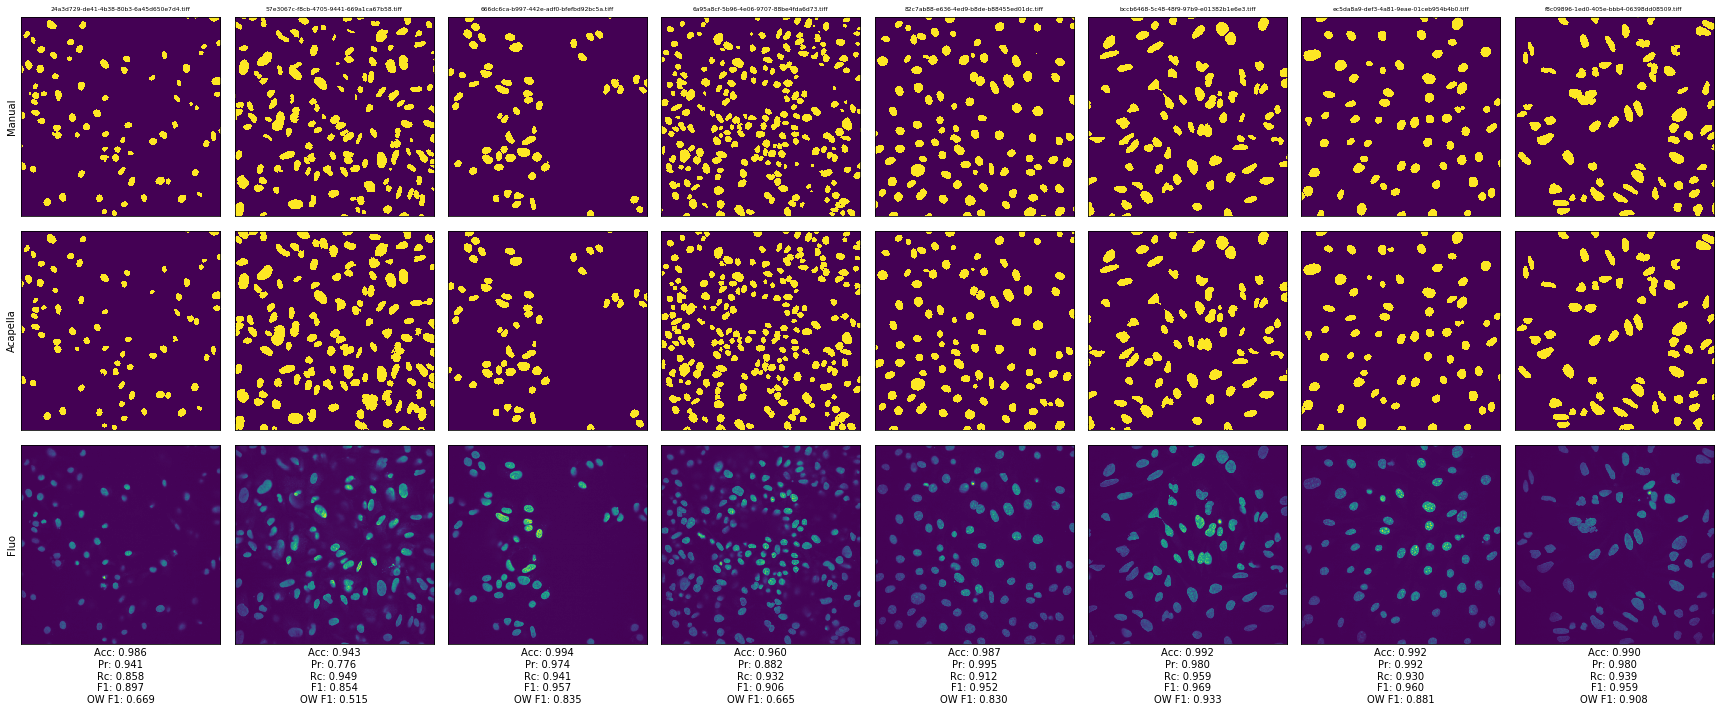

In [133]:
fig, axes = plt.subplots(ncols=8, nrows=3, figsize=(24,10))
for url, img_gt, img_ac_gt, img, ax in zip(urls, gt, acapella_gt, imgs, np.moveaxis(axes, 0, -1)):
    ax[0].imshow(img_gt)
    ax[1].imshow(img_ac_gt)
    ax[2].imshow(img)
    ax[0].set_title(url, fontsize=6)
    # Measure metrics
    acc, pr, rc, f1 = metrics.aprf(img_gt, img_ac_gt)
    ow_f1 = metrics.ow_score(img_gt, img_ac_gt)
    # Show metrics
    ax[2].set_xlabel(f'Acc: {acc:.3f}\nPr: {pr:.3f}\nRc: {rc:.3f}\nF1: {f1:.3f}\nOW F1: {ow_f1:.3f}')
    
    
axes[0, 0].set_ylabel('Manual')
axes[1, 0].set_ylabel('Acapella')
axes[2, 0].set_ylabel('Fluo')
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

Detect splits

In [134]:
from skimage.measure import label, regionprops

In [147]:
def find_difference(labeled, reference):
    diff_mask = np.zeros_like(reference)
    for l in np.unique(labeled)[1:]:
        mask = labeled == l
        union = reference & mask
        # If there is more than 2 objects in union, it's a split
        labeled_union = label(union)
        if np.max(labeled_union) > 1:
            diff_mask += union
    return diff_mask

def find_splits(pred, true):
    return find_difference(label(true), pred)

def find_merges(pred, true):
    return find_difference(label(pred), true)

In [156]:
def show_merges_and_splits(i):
    splits = find_splits(acapella_gt[i], gt[i])
    merges = find_merges(acapella_gt[i], gt[i])
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(24,6))

    for ax, img, title in zip(axes, 
                              [acapella_gt[i], gt[i], splits, merges],
                              ['Acapella', 'Ground truth', 'Splits', 'Merges']):
        ax.imshow(img)
        ax.set_title(title)

    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()

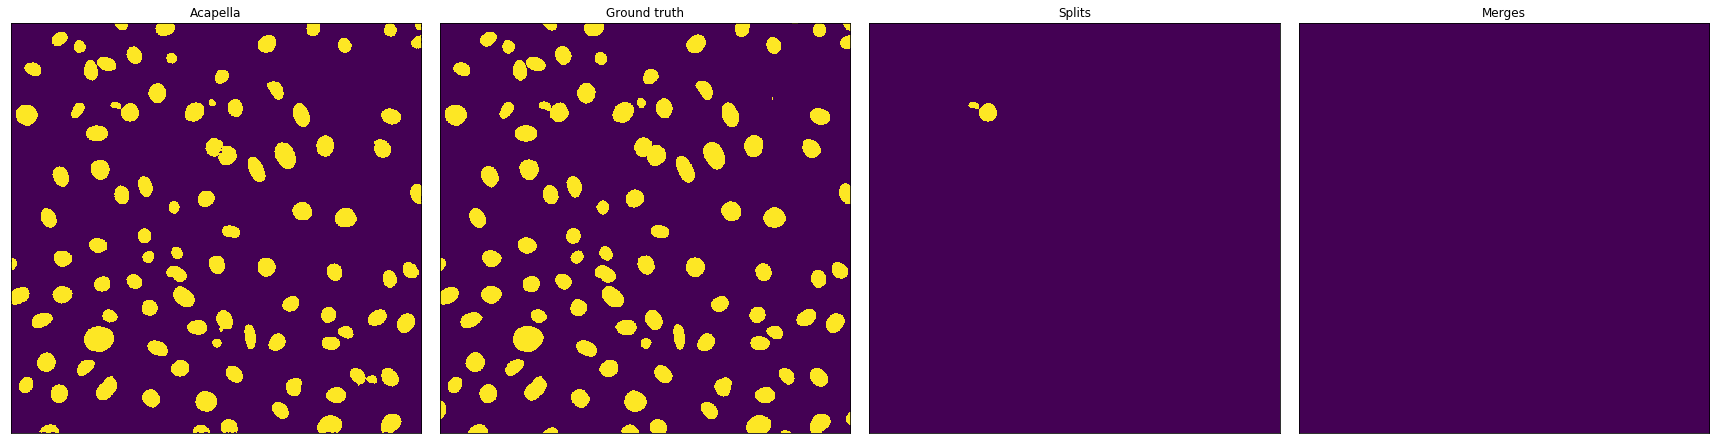

In [162]:
show_merges_and_splits(4)